# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [4]:
Teusink_ant ='../../data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [ ]:
#BIOMD64_05 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme0.5perts.csv')
#BIOMD64_08 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme0.8perts.csv')
#BIOMD64_09 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme0.9perts.csv')
#BIOMD64_11 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme1.1perts.csv')
#BIOMD64_12 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme1.2perts.csv')
BIOMD64_15 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv')
BIOMD64_15_1000 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts-1000.csv')

In [7]:
def run_BayesInf(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)


    N_ITERATIONS = 45000
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, 50000])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)
        

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 12,339


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 6.9072e+06


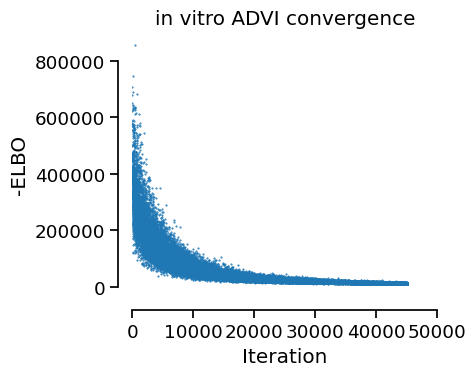

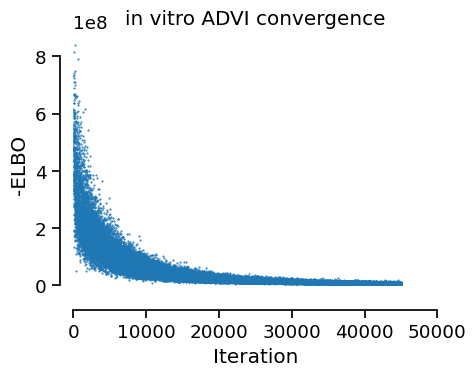

In [8]:
#trace05 = run_BayesInf(BIOMD64_05)
#trace08 = run_BayesInf(BIOMD64_08)
#trace09 = run_BayesInf(BIOMD64_09)
#trace11 = run_BayesInf(BIOMD64_11)
#trace12 = run_BayesInf(BIOMD64_12)
trace15 = run_BayesInf(BIOMD64_15)
trace15_1000 = run_BayesInf(BIOMD64_15_1000)

In [13]:
# Ex_05 = (trace05['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
# Ex_08 = (trace08['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
# Ex_09 = (trace09['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
# Ex_11 = (trace11['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
# Ex_12 = (trace12['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_15 = (trace15['posterior']['Ex']).to_numpy().squeeze()
Ey_15 = (trace15['posterior']['Ey']).to_numpy().squeeze()
Ex_15_1000 = (trace15_1000['posterior']['Ex']).to_numpy().squeeze()
Ey_15_1000 = (trace15_1000['posterior']['Ey']).to_numpy().squeeze()

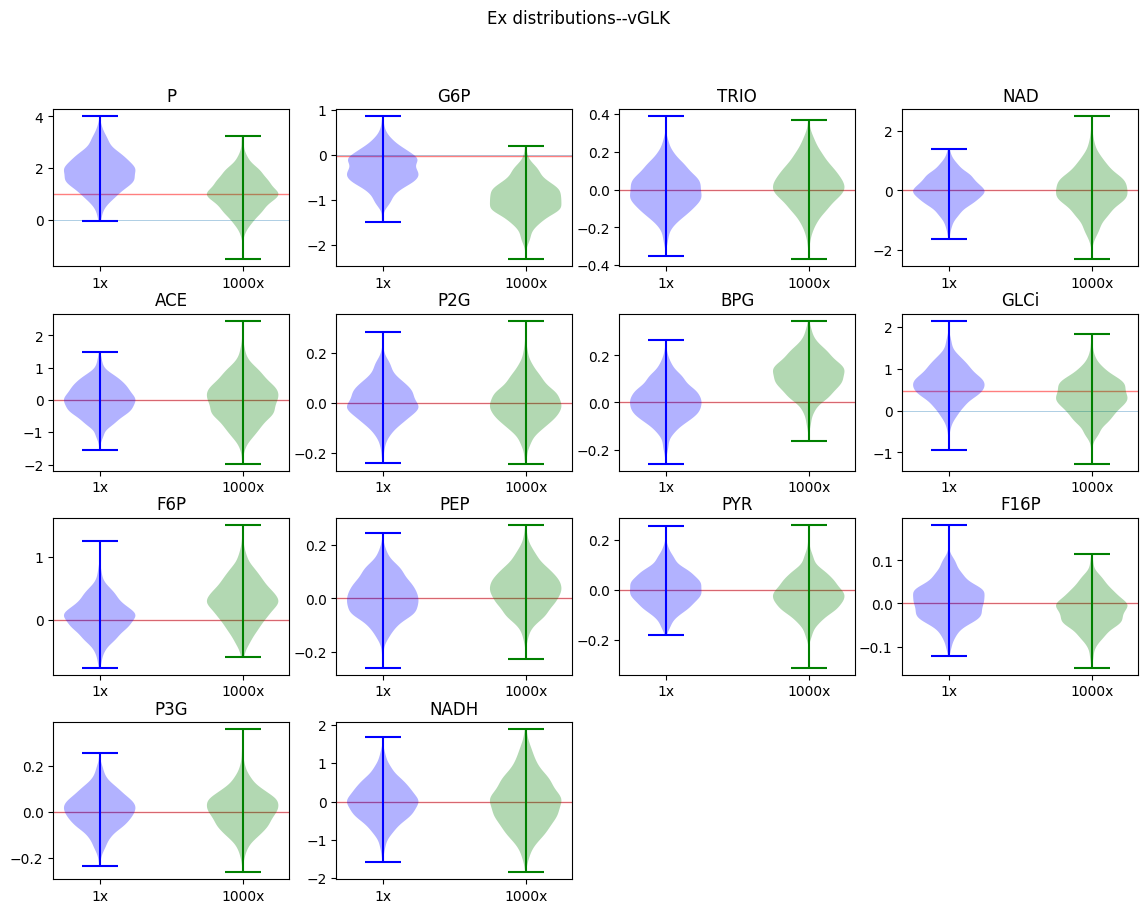

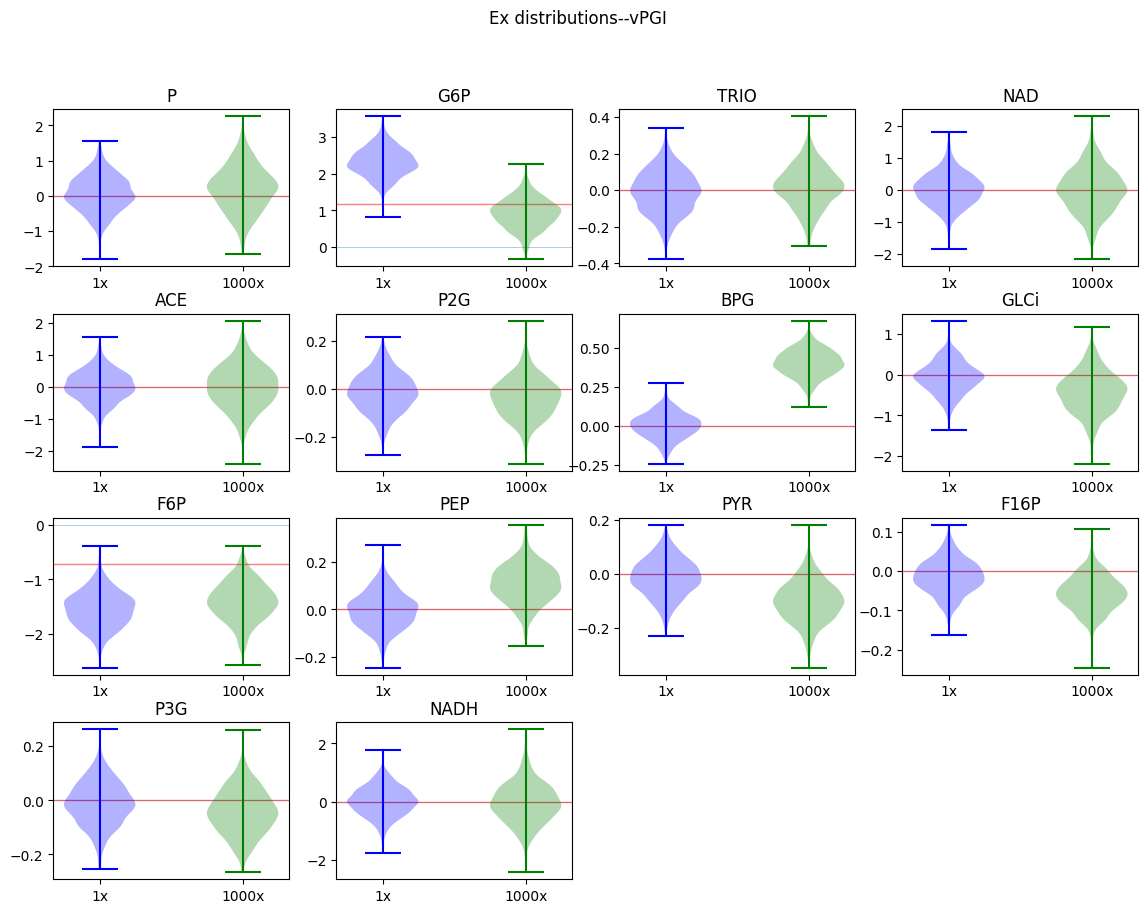

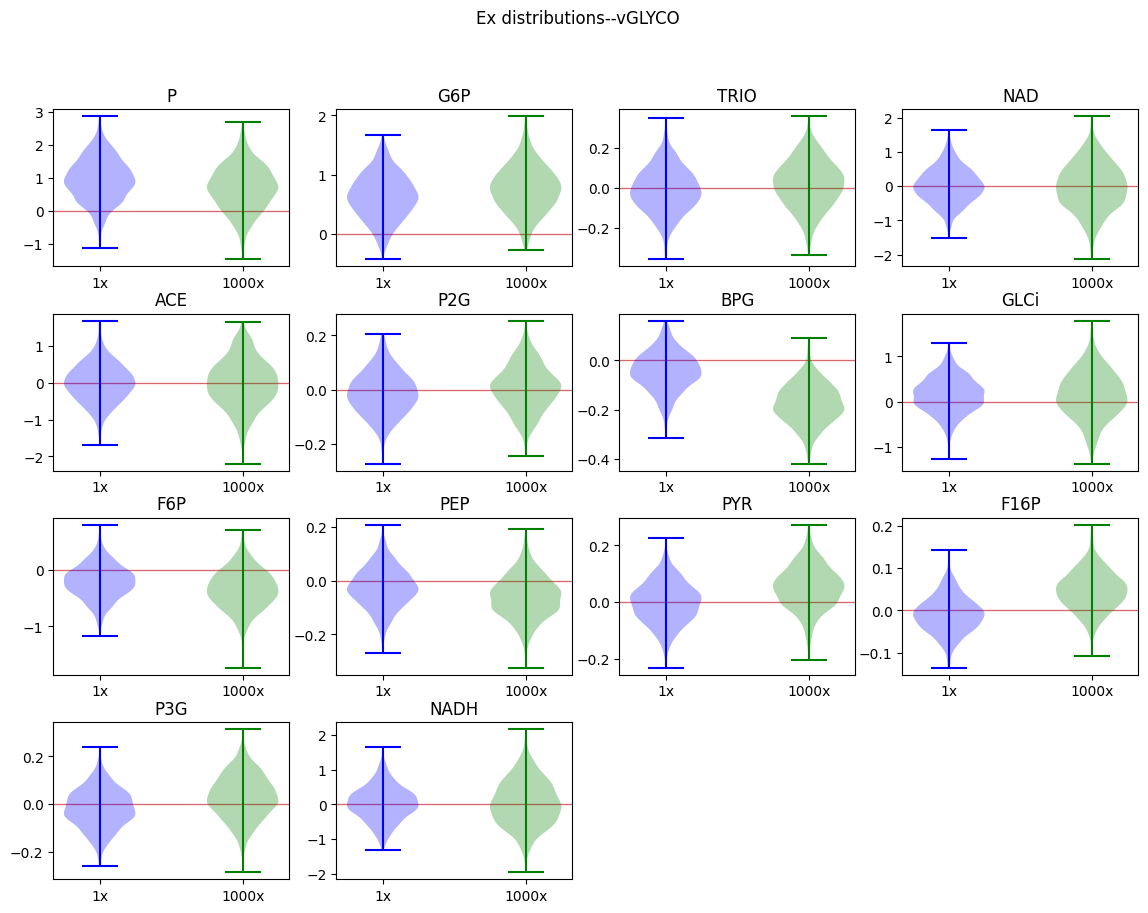

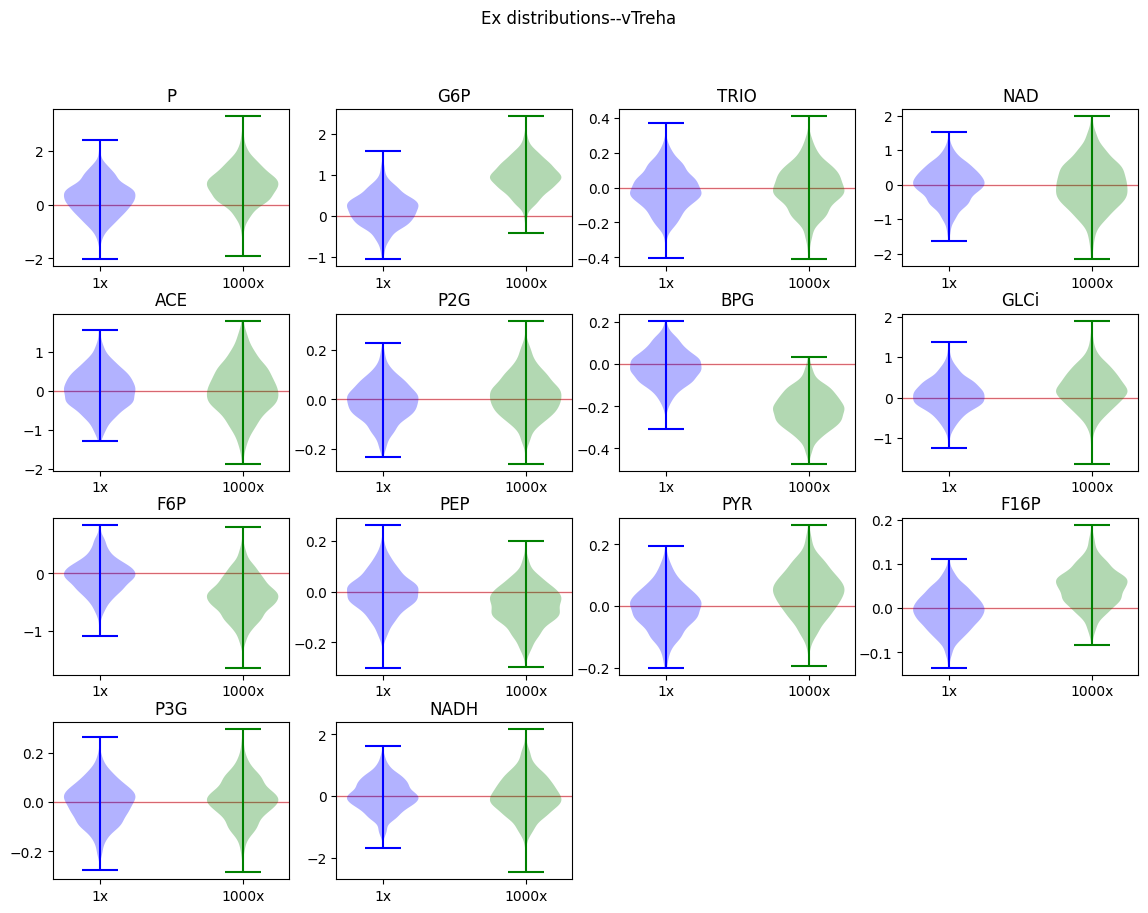

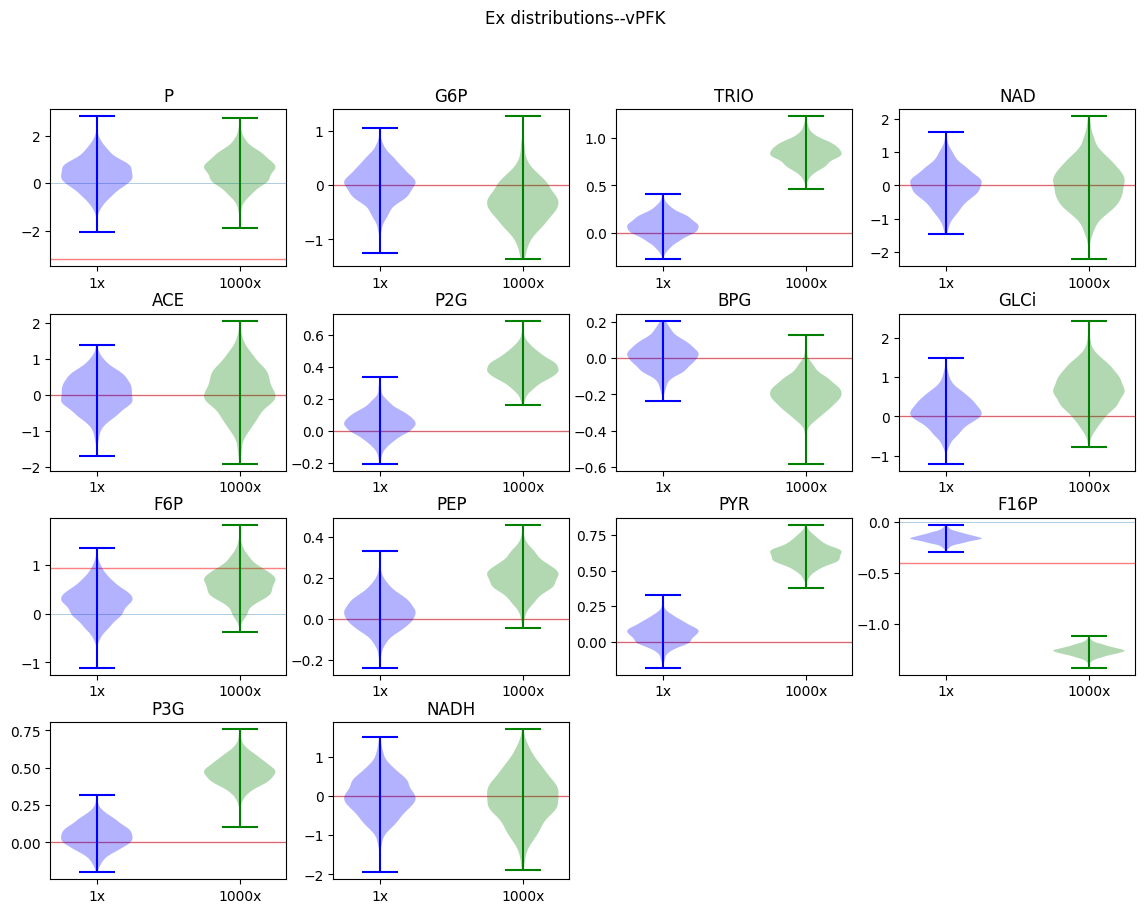

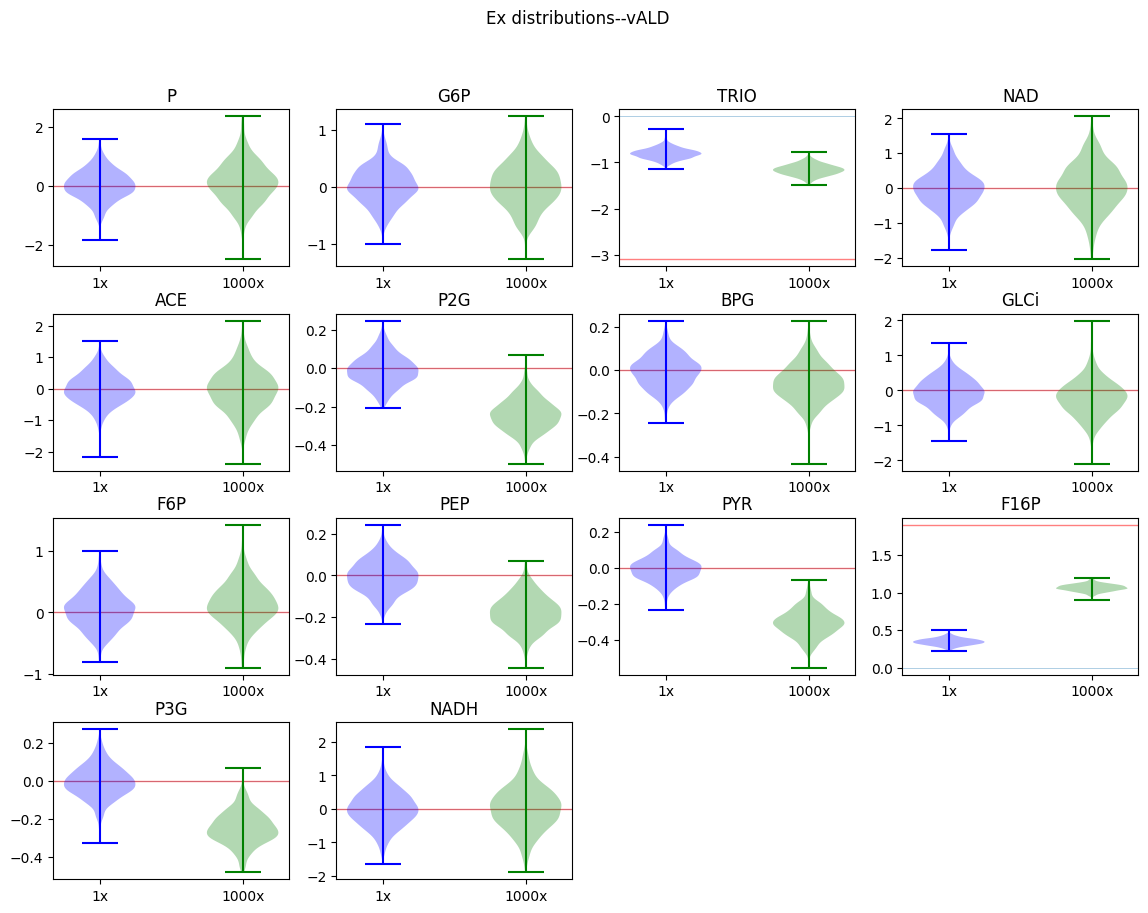

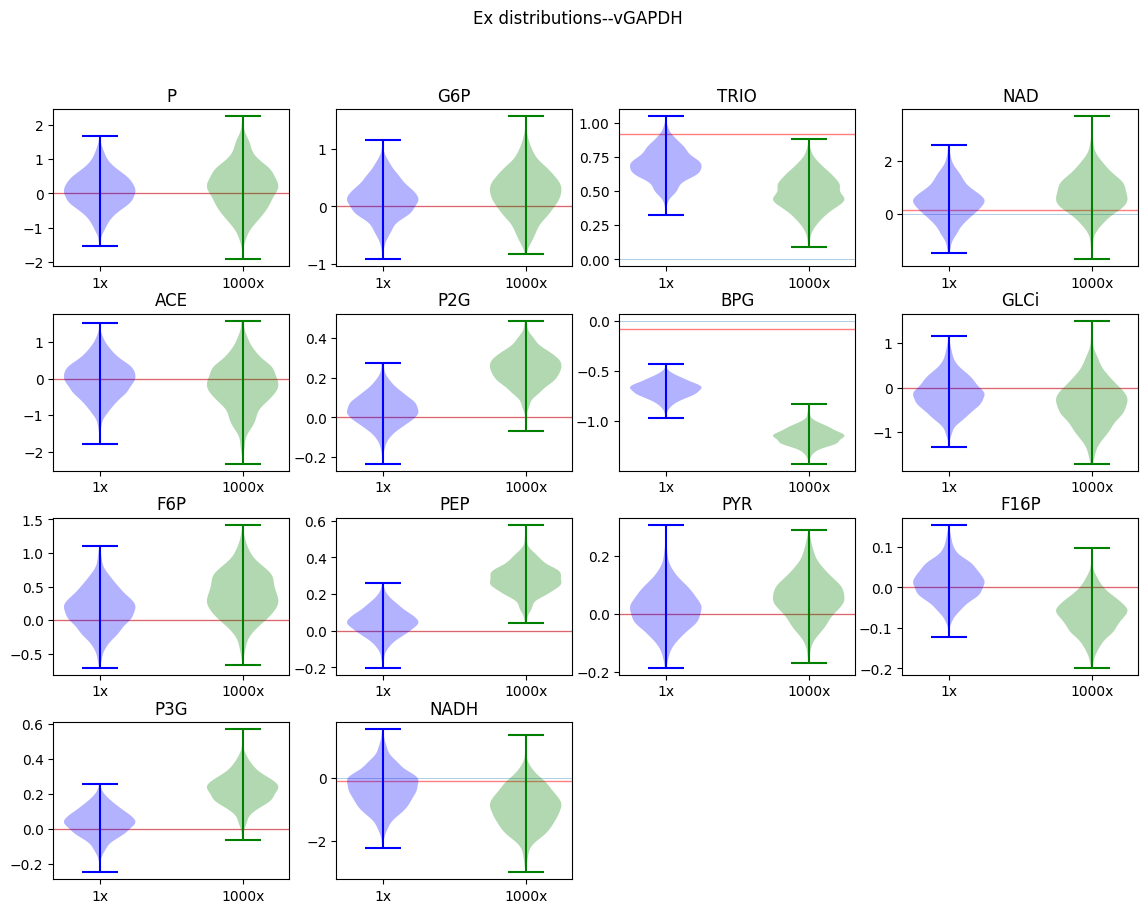

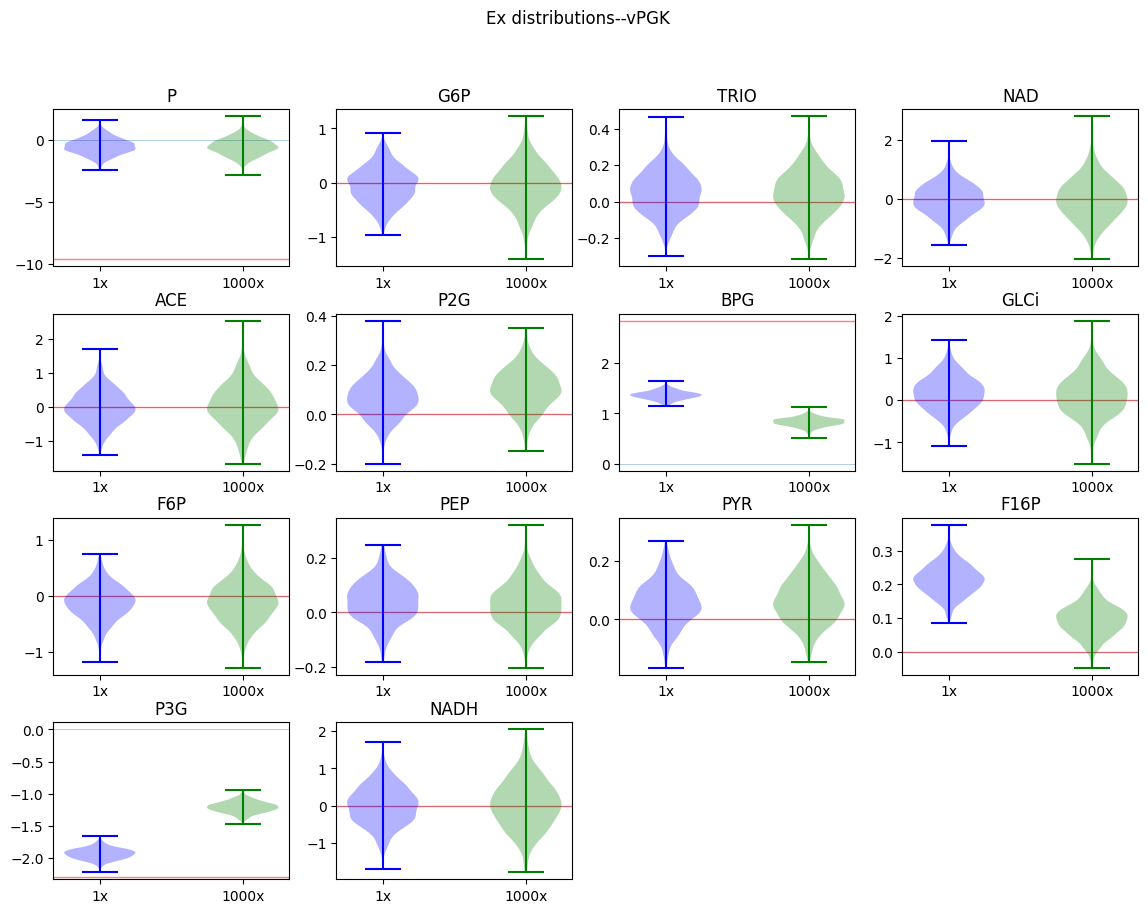

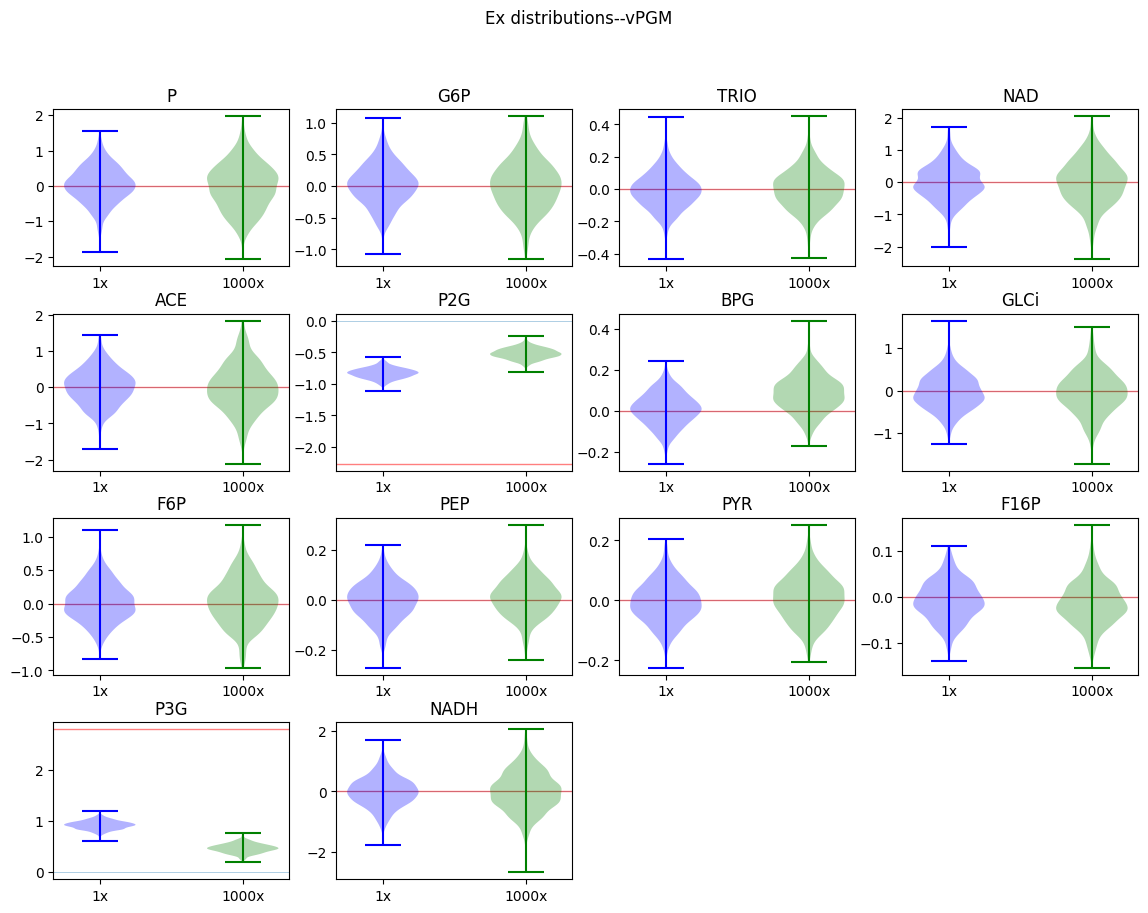

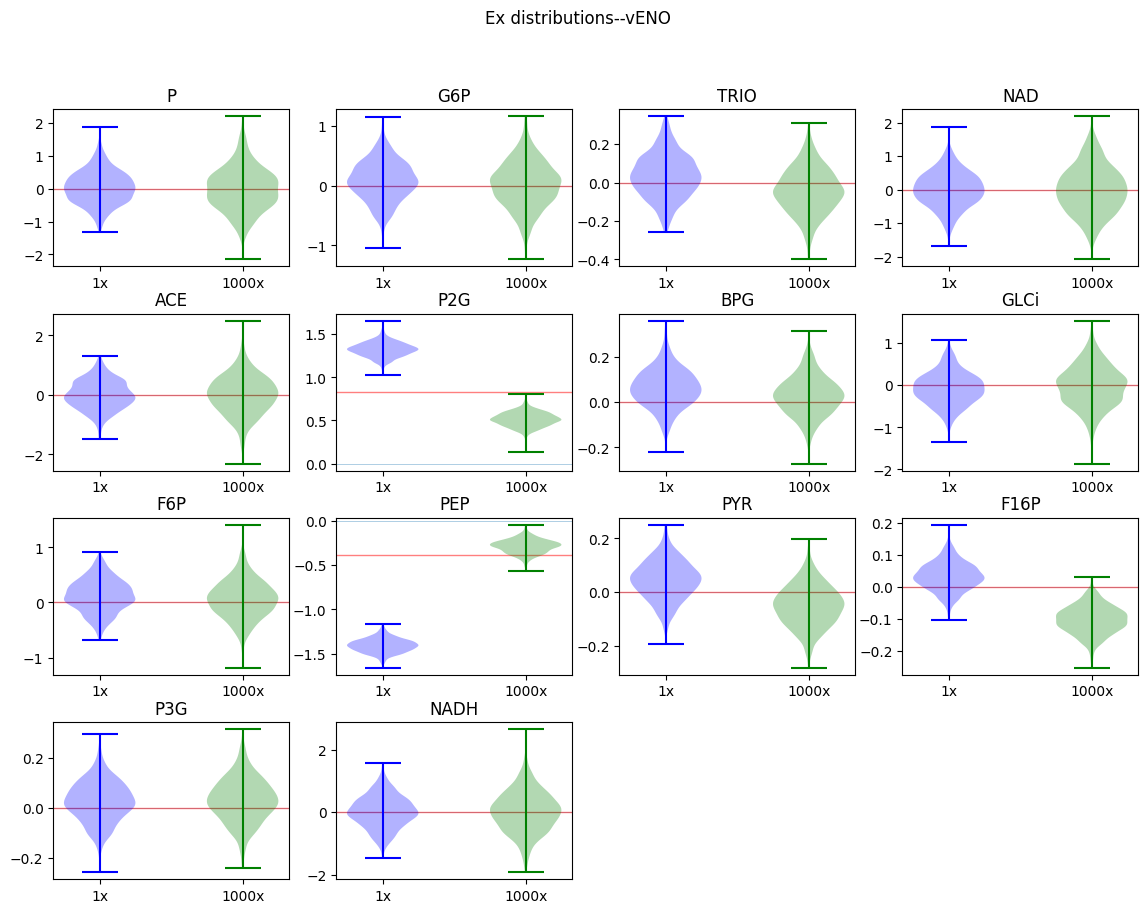

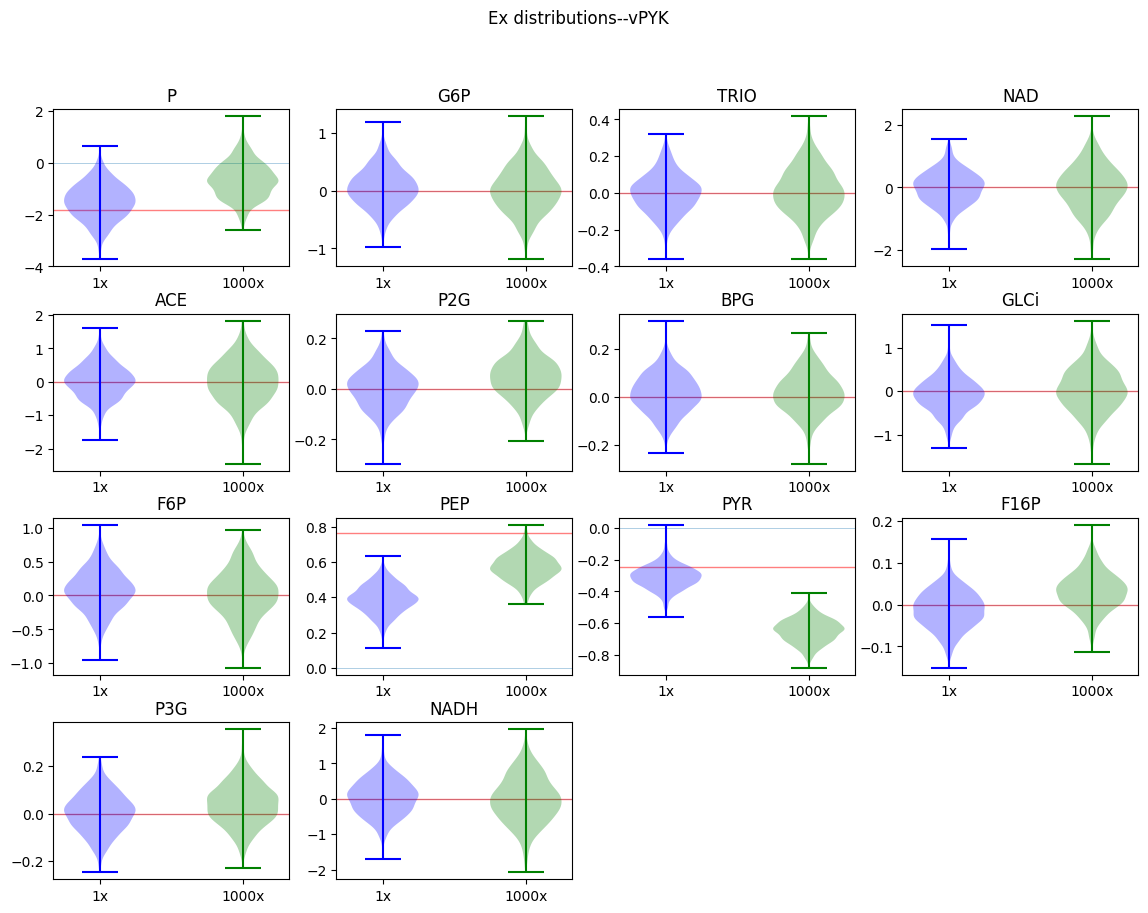

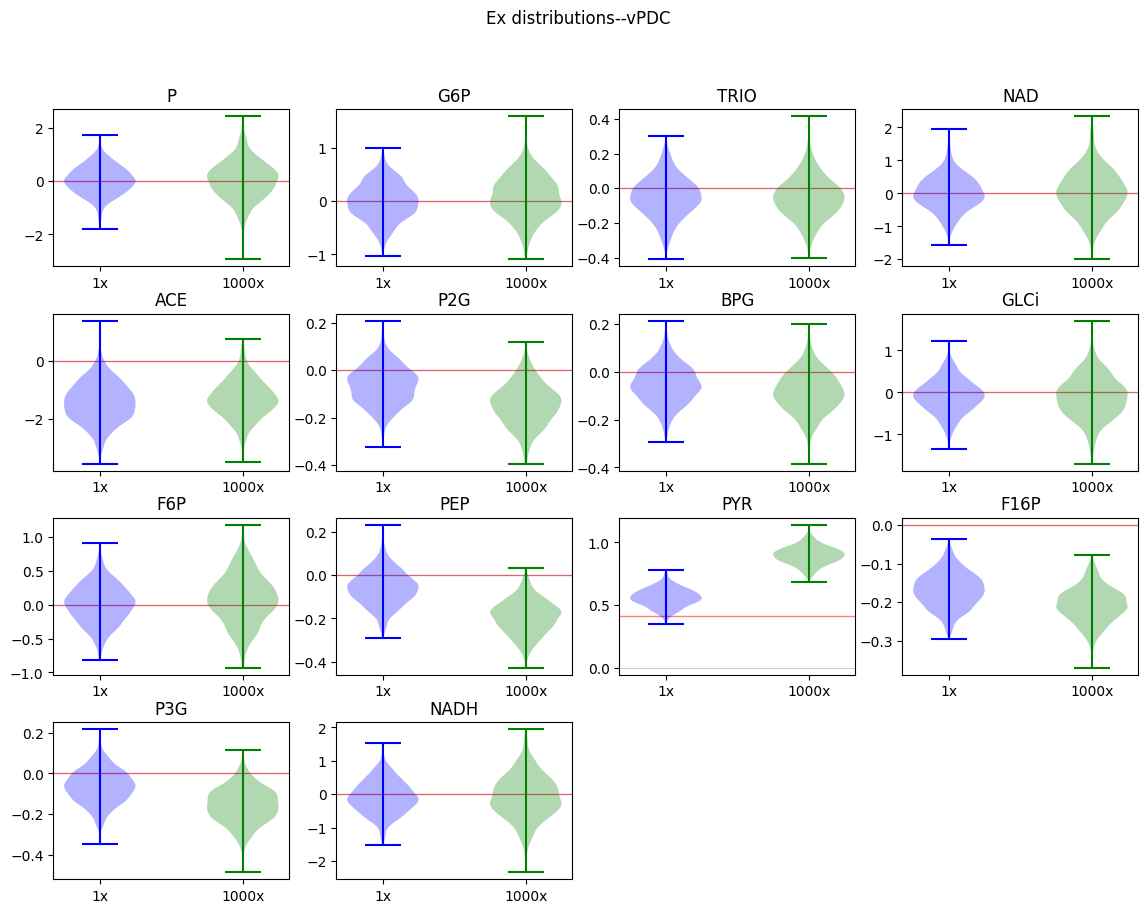

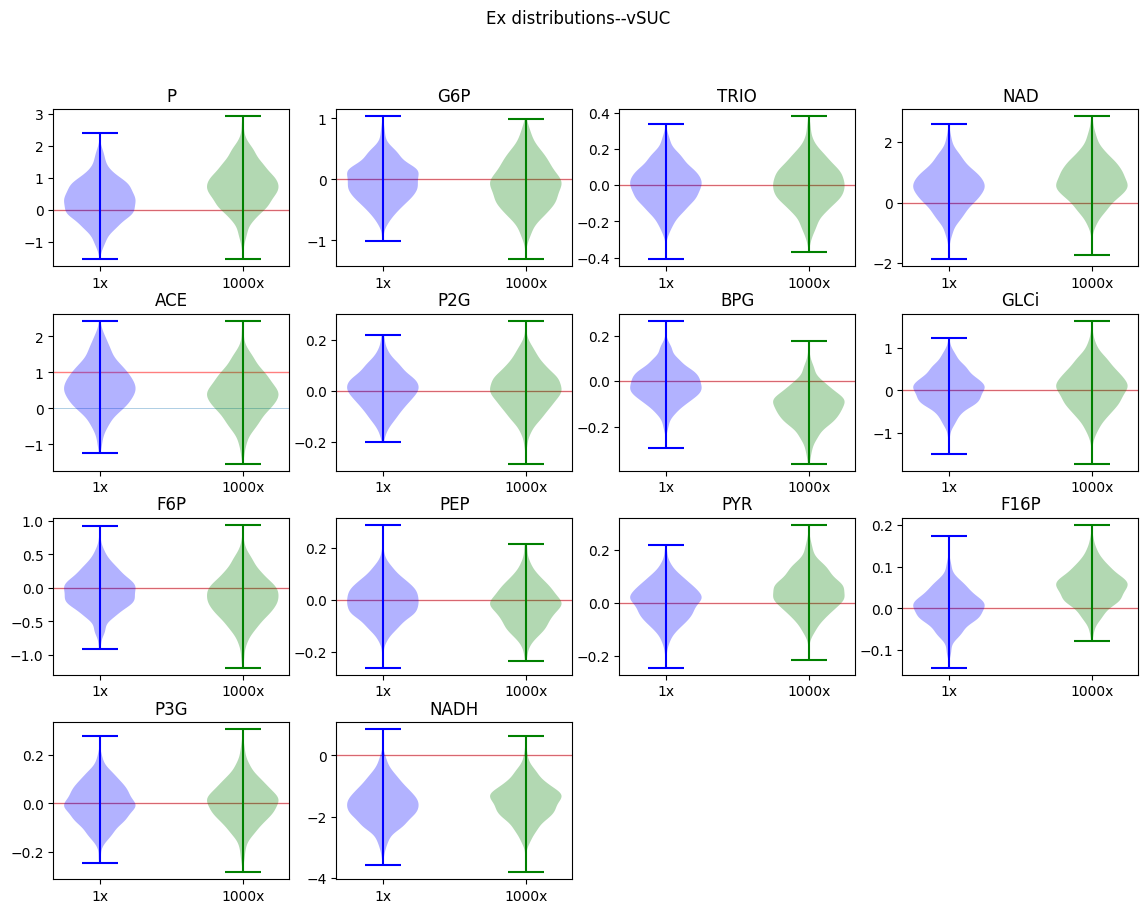

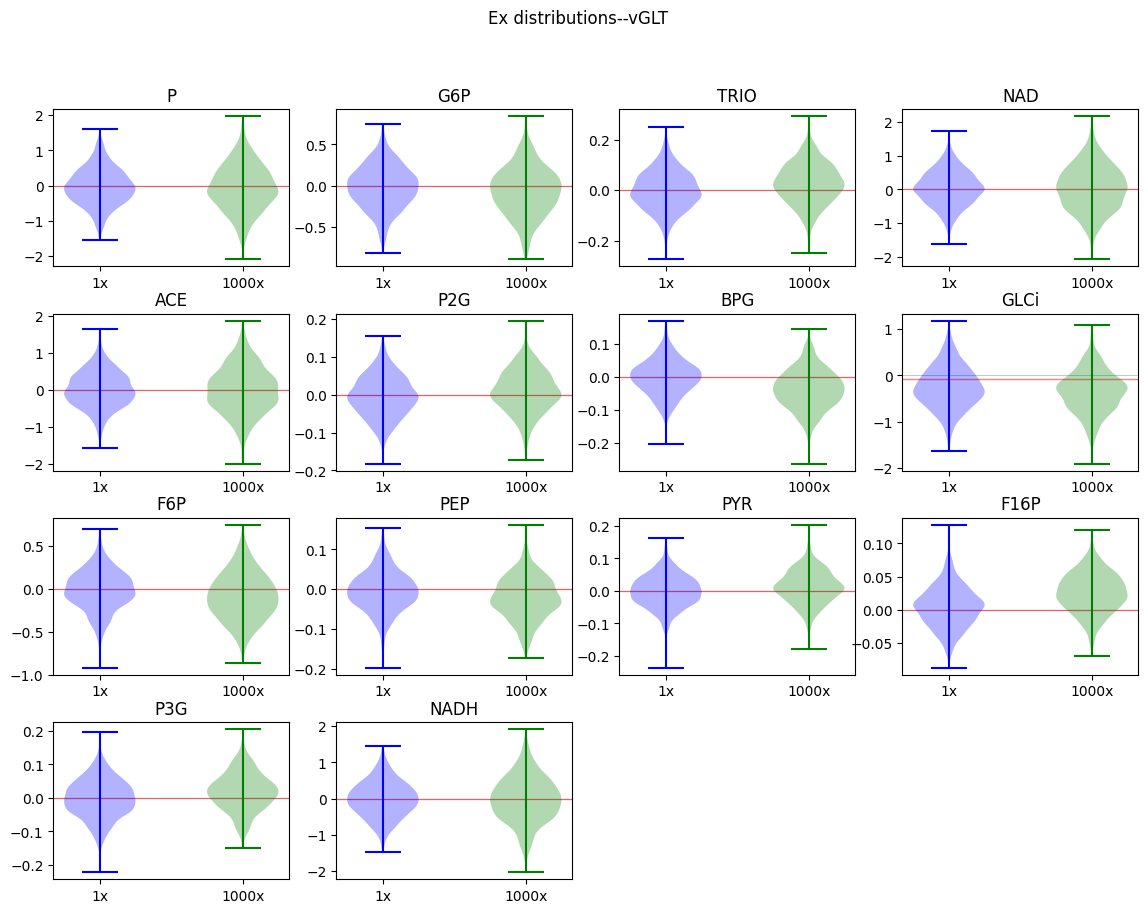

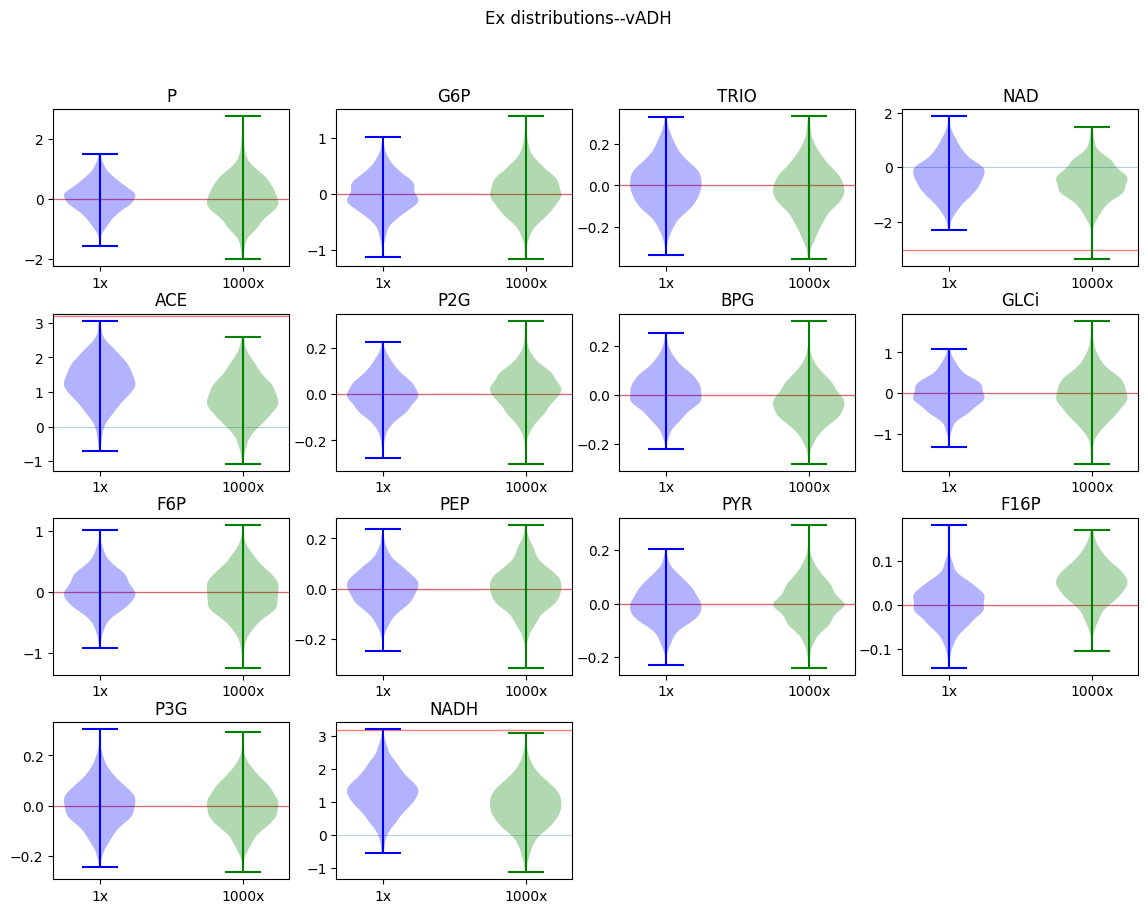

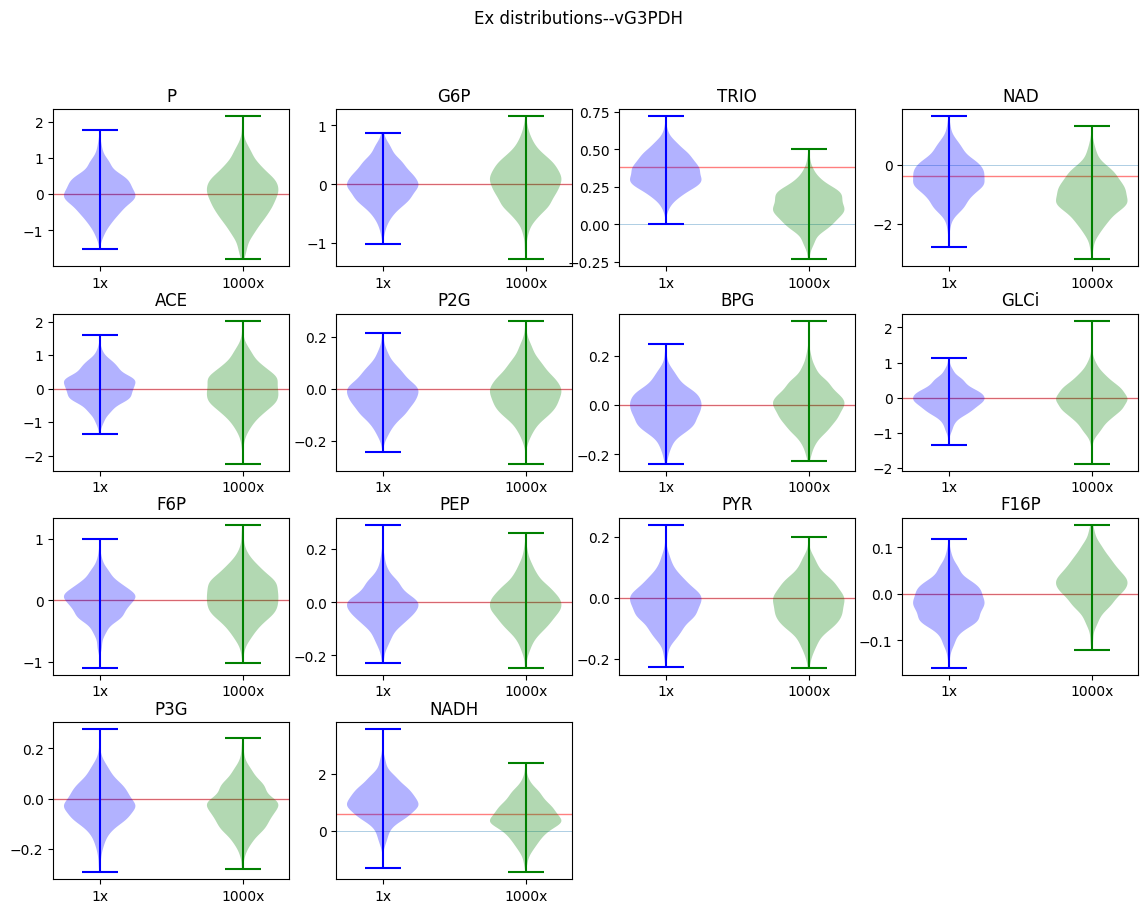

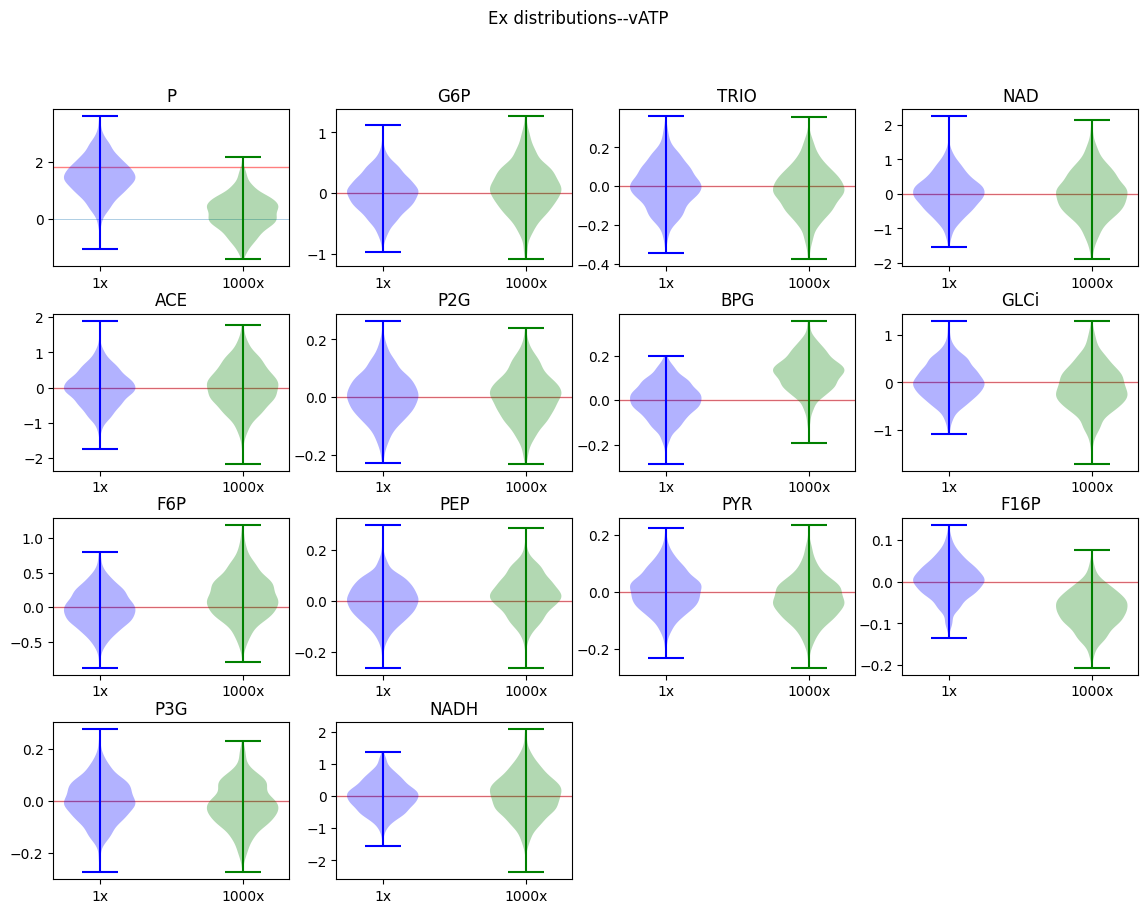

In [11]:
colors = ['blue', 'green', '#fa8602', 'magenta', '#07f53b', '#2312b8']

for i,rxn in enumerate(r.getReactionIds()): #['vADH']
    
    fig, ax = plt.subplots(4,4, figsize = (14,10))
    ii=-1
    
    fig.suptitle(f'Ex distributions--{rxn}\n')
    plt.setp(ax, xticks=range(7), xticklabels=['0', '1x', '1000x', '0.9','1.1', '1.2', '1.5'])
    plt.subplots_adjust(hspace=0.3)
    
    for j,met in enumerate(r.getFloatingSpeciesIds()): # ['TRIO'])
        if j%4==0:
            ii += 1

        met_traces=[]
        for trace in ([Ex_15.transpose(1, 2, 0), Ex_15_1000.transpose(1, 2, 0)]): 
            met_traces.append(trace[i,j,:]) 
            
        met_traces = np.array(met_traces).T

        plots = ax[ii, j%4].violinplot(met_traces)

        # Set the color of the violin patches
        for pc, color in zip(plots['bodies'], colors):
            pc.set_facecolor(color)
        plots['cbars'].set_colors(colors)
        plots['cmaxes'].set_colors(colors)
        plots['cmins'].set_colors(colors)
        
        ax[ii, j%4].axhline(0, linewidth=0.5, zorder=0, alpha=0.5)
        ax[ii, j%4].axhline(r.getScaledElasticityMatrix()[i,j], linewidth=1, zorder=0, alpha=0.5,color='red')
        ax[ii, j%4].set_title(met)
    
    fig.delaxes(ax[3,2]) 
    fig.delaxes(ax[3,3]) 

## Backcalculating to check if there are multiple elasticity solutions

In [14]:
med_Ex = np.median(Ex_15, axis=0)
med_Ey = np.median(Ey_15, axis=0)
med_Ex_1000 = np.median(Ex_15_1000, axis=0)
med_Ey_1000 = np.median(Ey_15_1000, axis=0)


In [15]:
# d_df is the flux calculated using the Bayesian inference MCMC POSTERIORS for elasticity
vn = BIOMD64_15.en.values * (np.ones(BIOMD64_15.en.T.shape) + med_Ex@(BIOMD64_15.xn.T) + med_Ey@(BIOMD64_15.yn.T)).T
vn_df = pd.DataFrame(vn)
vn_df.columns = BIOMD64_15.vn.columns #r.getReactionIds()
vn_df

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.857413,1.096739,0.962786,0.988833,1.007536,1.039130,1.075904,0.969126,1.053069,1.061095,1.061987,1.027642,0.989316,1.198950,1.038363,1.029563,1.048812
2,1.084789,0.483479,0.814643,0.951142,0.990886,0.997437,0.965165,1.010729,0.992730,0.977281,0.991166,1.000931,1.012010,1.005498,1.007374,1.001797,0.999677
3,0.994646,0.987196,1.333970,0.965825,0.855193,0.987388,1.056023,0.818341,0.971122,1.009336,1.009902,1.044608,0.977956,0.968565,0.963831,0.986716,0.870120
4,1.000321,0.981206,0.920951,1.463252,0.895690,0.992081,1.038806,0.873143,0.979525,1.005846,0.999796,1.033126,0.984486,0.980343,0.973747,0.990457,0.914050
5,1.040536,1.102961,0.946924,0.979778,1.341093,0.978817,0.911347,1.046817,0.989263,0.938345,0.964582,0.992636,1.027339,1.011608,1.003706,0.995168,1.008939
6,1.007408,1.015663,0.990143,0.996535,1.006977,1.404573,0.980740,0.971973,0.999516,0.982677,0.995034,1.027748,1.004715,1.001410,1.000256,1.002331,1.000972
7,1.031844,1.041267,1.010895,1.005546,1.056490,1.105833,0.865165,0.982908,1.007184,0.909521,0.995016,1.241985,0.786100,1.016466,1.013531,0.973464,1.052208
8,1.000529,1.000778,1.005262,1.002073,0.999143,1.002803,1.073516,1.246198,0.998806,0.990055,0.997823,1.012862,0.997242,1.000552,0.998887,1.000334,1.000995
9,0.999352,1.002104,1.006648,1.001182,0.993958,1.003305,1.053726,1.104569,1.326436,0.989033,0.997509,1.018103,0.997789,1.000839,0.998542,1.003006,1.000546


In [17]:
# d_df is the flux calculated using the Bayesian inference MCMC POSTERIORS for elasticity
vn_1000 = BIOMD64_15_1000.en.values * (np.ones(BIOMD64_15_1000.en.T.shape) + med_Ex@(BIOMD64_15_1000.xn.T) + med_Ey@(BIOMD64_15_1000.yn.T)).T
vn_1000_df = pd.DataFrame(vn_1000)
vn_1000_df.columns = BIOMD64_15_1000.vn.columns #r.getReactionIds()
vn_1000_df.head()

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.857413,1.096739,0.962786,0.988833,1.007536,1.039130,1.075904,0.969126,1.053069,1.061095,1.061987,1.027642,0.989316,1.198950,1.038363,1.029563,1.048812
2,1.084789,0.483479,0.814643,0.951142,0.990886,0.997437,0.965165,1.010729,0.992730,0.977281,0.991166,1.000931,1.012010,1.005498,1.007374,1.001797,0.999677
3,0.994646,0.987196,1.333970,0.965825,0.855193,0.987388,1.056023,0.818341,0.971122,1.009336,1.009902,1.044608,0.977956,0.968565,0.963831,0.986716,0.870120
4,1.000321,0.981206,0.920951,1.463252,0.895690,0.992081,1.038806,0.873143,0.979525,1.005846,0.999796,1.033126,0.984486,0.980343,0.973747,0.990457,0.914050


Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

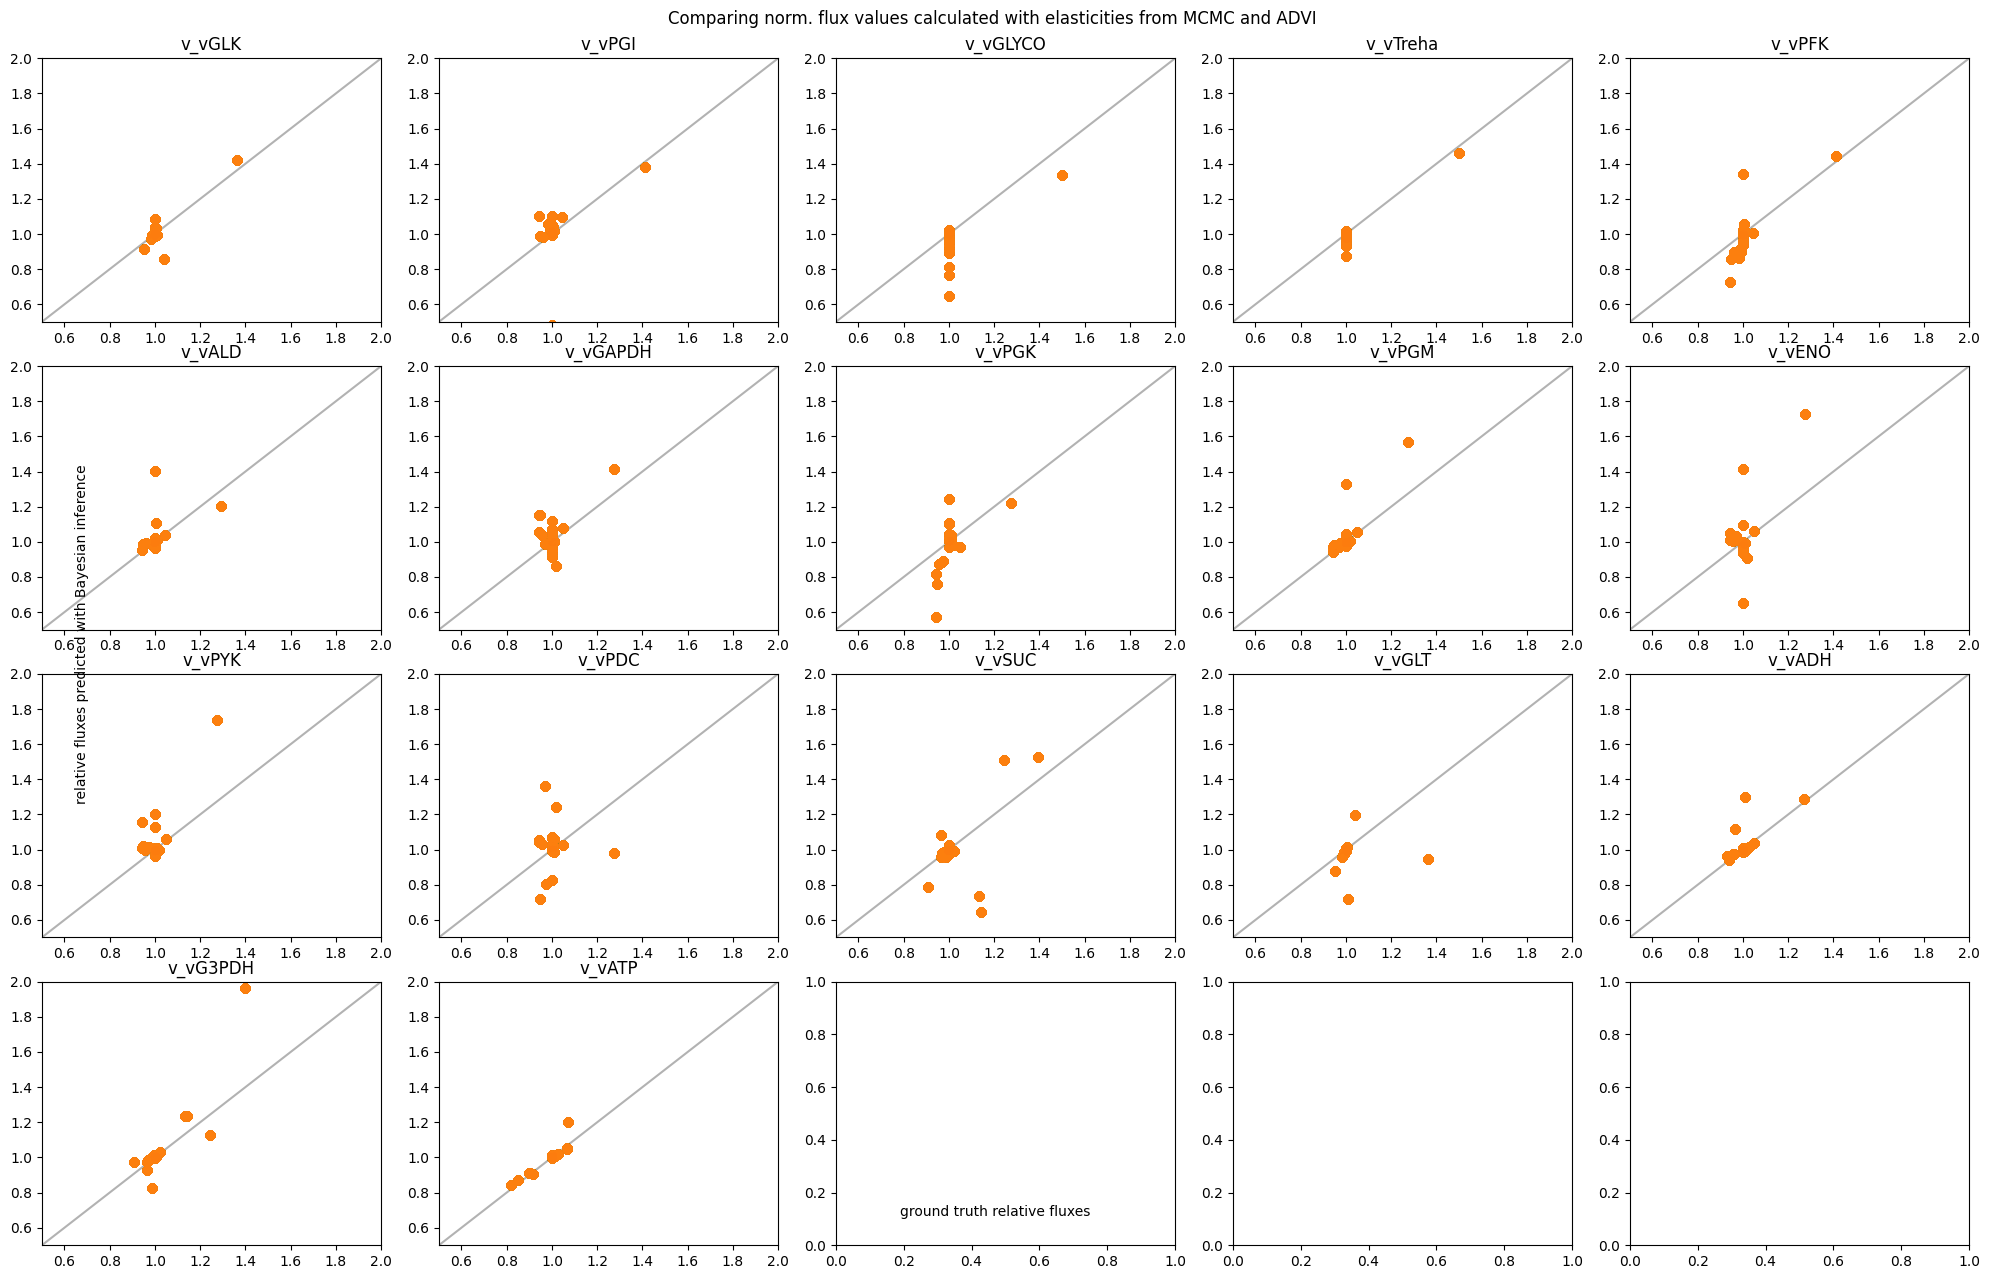

In [19]:
fig, axs = plt.subplots(4,5, figsize=(20, 13)) 
idx_starter = -1

fig.suptitle('Comparing norm. flux values calculated with elasticities from MCMC and ADVI \n')
fig.tight_layout()

lims = [0.5,2]

for i,col in enumerate(vn_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(BIOMD64_15.vn[col], vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].scatter(BIOMD64_15_1000.vn[col], vn_1000_df[col], alpha=0.3)
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

### Subtracting the vn values from fluxes calculated using elasticity posteriors

In [20]:
mcmc_dif = vn_df-BIOMD64_15.vn
mcmc_dif[mcmc_dif < 1E-1] = 0 
mcmc_dif

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160149,0.000000,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.113228,0.000000,0.000000,0.000000,0.000000,0.101813,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.102396,0.0,0.0,0.340527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.0,0.000000,0.0,0.0,0.000000,0.404449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.0,0.000000,0.0,0.0,0.000000,0.100278,0.000000,0.000000,0.000000,0.000000,0.000000,0.223336,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.245744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.104203,0.326070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
advi_dif = vn_1000_df-BIOMD64_15_1000.vn
advi_dif[advi_dif < 1E-1] = 0 
advi_dif.head(50)

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160149,0.000000,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.113228,0.000000,0.000000,0.000000,0.000000,0.101813,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.102396,0.0,0.0,0.340527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.0,0.000000,0.0,0.0,0.000000,0.404449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.0,0.000000,0.0,0.0,0.000000,0.100278,0.000000,0.000000,0.000000,0.000000,0.000000,0.223336,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.245744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.104203,0.326070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
